<a href="https://colab.research.google.com/github/shank10/MLrefresh/blob/main/skewed_data_breast_cancer_mortality_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# load and summarize the dataset
from pandas import read_csv
# define the dataset location
filename ='/content/haberman.csv'
# define the dataset column names
columns = ['age','year','nodes','class']
# load the csv file as a data frame
dataframe = read_csv(filename, header=None, names=columns)
# summarize each column
report = dataframe.describe()
print(dataframe.head())
#All values are int. We should look at it visually too.
print(report)
#All operations were performed between 1958 to 1969

   age  year  nodes  class
0   30    64      1      1
1   30    62      3      1
2   30    65      0      1
3   31    59      2      1
4   31    65      4      1
              age        year       nodes       class
count  306.000000  306.000000  306.000000  306.000000
mean    52.457516   62.852941    4.026144    1.264706
std     10.803452    3.249405    7.189654    0.441899
min     30.000000   58.000000    0.000000    1.000000
25%     44.000000   60.000000    0.000000    1.000000
50%     52.000000   63.000000    1.000000    1.000000
75%     60.750000   65.750000    4.000000    2.000000
max     83.000000   69.000000   52.000000    2.000000


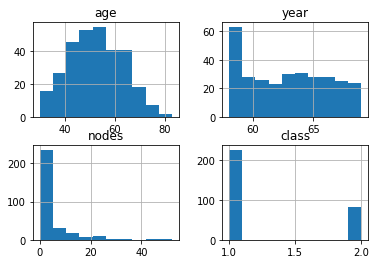

In [9]:
from matplotlib import pyplot
%matplotlib inline
dataframe['class'].value_counts()
dataframe.hist()
pyplot.show()
#So class 2 is about 25% of the overall population
#What the heck, lets get the exact percentage

In [12]:
from collections import Counter
# summarize the class distribution
target = dataframe['class'].values
counter = Counter(target)
for k,v in counter.items():
  per = v / len(target) * 100
  print('Class=%d, Count=%d, Percentage=%.3f%%'% (k, v, per))

Class=1, Count=225, Percentage=73.529%
Class=2, Count=81, Percentage=26.471%


In [13]:
# So the skew exists. And this should prompt us to evaluate various algos
# Lets evaluate candidate models using repeated stratifiedk-fold cross-validation
# We will use K=10, which means each training set will contain 306/10 or 30 samples. 
# Also we should maintain the same distribution of the two classes in each batch 74:26
# baseline model and test harness for the haberman datasetfrom collections import Counter
from numpy import mean, std
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import brier_score_loss
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyClassifier



In [16]:
# load the dataset
def load_dataset(full_path):
# load the dataset as a numpy array
  data = read_csv(full_path, header=None)
  # retrieve numpy array
  data = data.values
  # split into input and output elements
  X, y = data[:, :-1], data[:, -1]
  # label encode the target variable to have the classes 0 and 1
  y = LabelEncoder().fit_transform(y)
  return X, y
# calculate brier skill score (BSS)
def brier_skill_score(y_true, y_prob):
  # calculate reference brier score
  ref_probs = [0.26471 for _ in range(len(y_true))]
  bs_ref = brier_score_loss(y_true, ref_probs)
  # calculate model brier score
  bs_model = brier_score_loss(y_true, y_prob)
  # calculate skill score
  return 1.0 - (bs_model / bs_ref)
# evaluate a model
def evaluate_model(X, y, model):
  # define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  # define the model evaluation metric
  metric = make_scorer(brier_skill_score, needs_proba=True)
  # evaluate models
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores
# define the location of the dataset
full_path ='/content/haberman.csv'
# load the dataset
X, y = load_dataset(full_path)
# summarize the loaded dataset
print(X.shape, y.shape, Counter(y))
# define the reference model
model = DummyClassifier(strategy='prior')
# evaluate the model
scores = evaluate_model(X, y, model)
print('Mean BSS: %.3f (%.3f)'% (mean(scores), std(scores)))

(306, 3) (306,) Counter({0: 225, 1: 81})
Mean BSS: -0.000 (0.000)
